# Penerimaan Negara I

Konteks kompetisi ini adalah forecasting realisasi penerimaan negara dari sektor perpajakan. Forecasting memiliki peran penting dalam pengelolaan keuangan negara. Kapabilitas yg memadai dalam meramalkan realisasi penerimaan yang masuk ke kas negara dari waktu ke waktu dalam suatu periode tahun anggaran tertentu sangat penting untuk perencanaan kas dan pembiayaan. Kegagalan dalam peramalan realisasi penerimaan negara dapat berdampak pada rendahnya tingkat efektivitas dan efisiensi pengelolaan pemenuhan kas dan pembiayaan. Pada kasus ini, peserta diminta untuk mengembangkan model prediksi/ forecasting berdasarkan data historis yang diberikan, kemudian melakukan prediksi realisasi penerimaan negara selama kurun waktu tertentu sesuai dengan dataset yang telah diberikan. Penilaian dilakukan dengan pengukuran tingkat error prediksi dibandingkan nilai aktual. Pemenang dipilih dari peserta dengan nilai prediksi yang memiliki tingkat error paling rendah. Metrik evaluasinya sendiri adalah Mean Absolute Error (MAE).

In [ ]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 8.6 MB/s eta 0:00:00


In [ ]:
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.6/409.6 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.8/226.8 kB 26.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 8.6 MB/s eta 0:00:00


In [ ]:
# For Data Manipulation
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# For Machine Learning
import optuna
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import StackingRegressor

In [ ]:
train = pd.read_csv("/content/drive/MyDrive/KEMENKEU2023/DATA BATTLE 2023/PENERIMAAN I/data_training.csv", sep = ";")

In [ ]:
test = pd.read_csv("/content/drive/MyDrive/KEMENKEU2023/DATA BATTLE 2023/PENERIMAAN I/data_testing.csv", sep = ";")

In [ ]:
sub = pd.read_csv("/content/drive/MyDrive/KEMENKEU2023/DATA BATTLE 2023/PENERIMAAN I/sample_submission.csv", sep = ",")

In [ ]:
os.chdir("/content/drive/MyDrive/KEMENKEU2023/DATA BATTLE 2023/PENERIMAAN I/SUBMISSIONS")

# Train Dataset

*   Missing Values pada kolom X2 merupakan kota tersendiri pada train dan test sehingga jangan di drop
*   CatBoostRegressor and RandomForestRegressor model terbaik
*   No need to make single model for each id
*   Mencoba stacking CatBoost dan RandomForestRegressor using LinearRegression as meta model




In [ ]:
train.head()

,Date,X1,X2,Y
0,07/01/12,,NaN,71864183015
1,07/01/12,,A,32640358590
2,07/01/12,,B,30845698143
3,07/01/12,,C,39580783266
4,07/01/12,,D,30442401289


In [ ]:
train.shape

(429999, 4)

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 429999 entries, 0 to 429998
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   Date    429999 non-null  object
 1   X1      429999 non-null  object
 2   X2      411191 non-null  object
 3   Y       429999 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 13.1+ MB


In [ ]:
train["X1"].unique()

array([' ', 'Propinsi 01', 'Propinsi 02', 'Propinsi 03', 'Propinsi 04',
       'Propinsi 05', 'Propinsi 06', 'Propinsi 07', 'Propinsi 08',
       'Propinsi 09', 'Propinsi 10', 'Propinsi 11', 'Propinsi 12',
       'Propinsi 13', 'Propinsi 14', 'Propinsi 15', 'Propinsi 16',
       'Propinsi 17', 'Propinsi 18', 'Propinsi 19', 'Propinsi 20',
       'Propinsi 21', 'Propinsi 22', 'Propinsi 23', 'Propinsi 24',
       'Propinsi 25', 'Propinsi 26', 'Propinsi 27', 'Propinsi 28',
       'Propinsi 29', 'Propinsi 30', 'Propinsi 31', 'Propinsi 32',
       'Propinsi 33', 'Propinsi 34'], dtype=object)

In [ ]:
train["X2"].unique()

array([nan, 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L',
       'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'Z', 'U'], dtype=object)

In [ ]:
train.isnull().sum()

Date        0
X1          0
X2      18808
Y           0
dtype: int64

In [ ]:
train.duplicated().sum()

0

In [ ]:
# Membuat beberapa fungsi pembantu
def preprocessing(train):
  # Make a copy of dataframe
  df = train.copy()

  # Change Date to datetime format
  df["Date"] = df["Date"].str.replace("/", "-")
  df["Date"] = pd.to_datetime(df["Date"])

  return df

def feature_engineer(train):
  # Make a copy of dataframe
  df = train.copy()
  df.index = df["Date"]
  df.drop("Date", axis = 1, inplace = True)

  # Make datetime features
  df["dayofweek"] = df.index.dayofweek
  df["dayofyear"] = df.index.dayofyear
  df["dayofmonth"] = df.index.day
  df["week"] = df.index.week
  df["quarter"] = df.index.quarter
  df["month"] = df.index.month
  df["year"] = df.index.year

  # Reset index
  df.reset_index(drop = True, inplace = True)

  return df

def pipeline(train):
  # Preprocessing
  train = preprocessing(train)

  # Drop missing values subset of X2
  train["X2"].fillna("ZZ", inplace = True)

  # One hot encode X1
  train = pd.concat([train, pd.get_dummies(train["X1"])], axis = 1)
  train.drop("X1", axis = 1, inplace = True)

  # One hot encode X2
  train = pd.concat([train, pd.get_dummies(train["X2"])], axis = 1)
  train.drop("X2", axis = 1, inplace = True)

  # Feature Engineering
  train = feature_engineer(train)

  return train

def plot_feature(propinsi, kota, i):
    df = train[train["X1"] == propinsi]
    df = df[df["X2"] == kota]
    df = df["Y"]
    g = sns.lineplot(df, ax = ax[i])
    g.set_title("Kota - " + kota)

In [ ]:
# Mengubah train melalui pipeline yang sudah dibuat
train = pipeline(train)

In [ ]:
# Melihat statistik deskriptif target
train["Y"].describe()

count    4.299990e+05
mean     5.793569e+10
std      2.175404e+11
min     -7.835930e+12
25%      3.003570e+10
50%      3.157152e+10
75%      4.065282e+10
max      1.802160e+13
Name: Y, dtype: float64

In [ ]:
# Membagi menjadi X dan y dengan y diambil log-nya berbasis 10
X = train.copy()
y = np.log10(np.abs(X.pop("Y")))

In [ ]:
# Melakukan Hyperparameter Tuning CatBoostRegressor
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

def objective(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1),
        'depth': trial.suggest_int('depth', 3, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 0.1, 10),
        'border_count': trial.suggest_int('border_count', 5, 255),
        'thread_count': -1,
        'verbose': 0,
        'loss_function': 'MAE',
        'random_seed': 42
    }

    model = CatBoostRegressor(**params)
    model.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=50, verbose=False)

    # Calculate the validation RMSE
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)

    return mae  # Objective is to minimize MAE

In [ ]:
# Create study
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

[I 2023-11-12 09:42:29,360] A new study created in memory with name: no-name-e50bd484-e046-45c3-b5c2-11c33a6718d1
[I 2023-11-12 09:42:40,890] Trial 0 finished with value: 0.08624154170211136 and parameters: {'iterations': 238, 'learning_rate': 0.028572391428335883, 'depth': 6, 'l2_leaf_reg': 8.35254720656711, 'border_count': 47}. Best is trial 0 with value: 0.08624154170211136.
[I 2023-11-12 09:43:13,930] Trial 1 finished with value: 0.051575277912157436 and parameters: {'iterations': 382, 'learning_rate': 0.07319170948141811, 'depth': 10, 'l2_leaf_reg': 5.476567916701257, 'border_count': 89}. Best is trial 1 with value: 0.051575277912157436.
[I 2023-11-12 09:44:35,672] Trial 2 finished with value: 0.08457095353112773 and parameters: {'iterations': 995, 'learning_rate': 0.003566709443824803, 'depth': 10, 'l2_leaf_reg': 5.488985130687439, 'border_count': 71}. Best is trial 1 with value: 0.051575277912157436.
[I 2023-11-12 09:45:04,742] Trial 3 finished with value: 0.08417491377375348 an

KeyboardInterrupt: ignored

In [ ]:
# Melakukan Hyperparameter Tuning CatBoostRegressor
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

def objective(trial):
    # Define the parameter space for the Random Forest Regressor
    params = {
        'max_depth': trial.suggest_int('max_depth', 5, 30),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 4)
    }

    # Create a Random Forest Regressor with the suggested hyperparameters
    rf = RandomForestRegressor(**params)

    # Fit the model to the training data
    rf.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = rf.predict(X_test)

    # Calculate the mean squared error
    mae = mean_absolute_error(y_test, y_pred)

    return mae

In [ ]:
# Create study
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

[I 2023-11-15 04:22:18,447] A new study created in memory with name: no-name-422a8f0f-ab6f-4924-bc2a-0c5f097b98b3
[I 2023-11-15 04:24:57,352] Trial 0 finished with value: 0.09996840492940481 and parameters: {'max_depth': 6, 'min_samples_split': 4, 'min_samples_leaf': 1}. Best is trial 0 with value: 0.09996840492940481.
[I 2023-11-15 04:30:05,154] Trial 1 finished with value: 0.069850816670447 and parameters: {'max_depth': 13, 'min_samples_split': 6, 'min_samples_leaf': 1}. Best is trial 1 with value: 0.069850816670447.
[I 2023-11-15 04:34:04,031] Trial 2 finished with value: 0.08071661390046471 and parameters: {'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 4}. Best is trial 1 with value: 0.069850816670447.
[I 2023-11-15 04:39:53,625] Trial 3 finished with value: 0.06377049294173286 and parameters: {'max_depth': 15, 'min_samples_split': 5, 'min_samples_leaf': 2}. Best is trial 3 with value: 0.06377049294173286.
[I 2023-11-15 04:47:38,492] Trial 4 finished with value: 0.04

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-19-299be0673f75>", line 3, in <cell line: 3>
    study.optimize(objective, n_trials=100)
  File "/usr/local/lib/python3.10/dist-packages/optuna/study/study.py", line 451, in optimize
    _optimize(
  File "/usr/local/lib/python3.10/dist-packages/optuna/study/_optimize.py", line 66, in _optimize
    _optimize_sequential(
  File "/usr/local/lib/python3.10/dist-packages/optuna/study/_optimize.py", line 163, in _optimize_sequential
    frozen_trial = _run_trial(study, func, catch)
  File "/usr/local/lib/python3.10/dist-packages/optuna/study/_optimize.py", line 251, in _run_trial
    raise func_err
  File "/usr/local/lib/python3.10/dist-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "<ipython-input-18-af69c66a8208>", line 

In [ ]:
model1 = RandomForestRegressor(n_estimators = 100)
model1.fit(X, y)

In [ ]:
params = {'iterations': 946, 'learning_rate': 0.09444984032141275, 'depth': 10, 'l2_leaf_reg': 5.127380121812485, 'border_count': 87}
model2 = CatBoostRegressor(**params)
model2.fit(X, y)

Learning rate set to 0.106725
0:	learn: 0.2381110	total: 240ms	remaining: 3m 59s
1:	learn: 0.2328019	total: 385ms	remaining: 3m 12s
2:	learn: 0.2282400	total: 540ms	remaining: 2m 59s
3:	learn: 0.2233275	total: 684ms	remaining: 2m 50s
4:	learn: 0.2194291	total: 792ms	remaining: 2m 37s
5:	learn: 0.2152444	total: 910ms	remaining: 2m 30s
6:	learn: 0.2118841	total: 986ms	remaining: 2m 19s
7:	learn: 0.2085616	total: 1.07s	remaining: 2m 13s
8:	learn: 0.2057613	total: 1.15s	remaining: 2m 7s
9:	learn: 0.2032713	total: 1.25s	remaining: 2m 3s
10:	learn: 0.2014476	total: 1.36s	remaining: 2m 2s
11:	learn: 0.1994720	total: 1.47s	remaining: 2m 1s
12:	learn: 0.1972653	total: 1.6s	remaining: 2m 1s
13:	learn: 0.1949130	total: 1.7s	remaining: 1m 59s
14:	learn: 0.1939372	total: 1.79s	remaining: 1m 57s
15:	learn: 0.1923695	total: 1.86s	remaining: 1m 54s
16:	learn: 0.1907163	total: 1.97s	remaining: 1m 53s
17:	learn: 0.1882857	total: 2.1s	remaining: 1m 54s
18:	learn: 0.1872580	total: 2.22s	remaining: 1m 54s


In [ ]:
# Mendefinisikan base model
model1 = CatBoostRegressor()
model2 = RandomForestRegressor()

# Mendefinisikan meta model
linear_model = LinearRegression()

# Mendefinisikan stacked regressor
stacked_regressor = StackingRegressor(
    estimators=[('catboost', model1), ('random_forest', model2)],
    final_estimator=linear_model
)

# Fit the stacked regressor on the training data
stacked_regressor.fit(X, y)

# Test Dataset

In [ ]:
test.head()

,id,Date,X1,X2
0,b1,30/07/22,Propinsi 04,Z
1,b2,30/07/22,Propinsi 05,NaN
2,b3,30/07/22,Propinsi 05,A
3,b4,30/07/22,Propinsi 05,B
4,b5,30/07/22,Propinsi 05,C


In [ ]:
test.shape

(47049, 4)

In [ ]:
test.isnull().sum()

id         0
Date       0
X1         0
X2      2078
dtype: int64

In [ ]:
test["X1"].unique()

array(['Propinsi 04', 'Propinsi 05', 'Propinsi 06', 'Propinsi 07',
       'Propinsi 08', 'Propinsi 09', 'Propinsi 10', 'Propinsi 11',
       'Propinsi 12', 'Propinsi 13', 'Propinsi 14', 'Propinsi 15',
       'Propinsi 16', 'Propinsi 17', 'Propinsi 18', 'Propinsi 19',
       'Propinsi 20', 'Propinsi 21', 'Propinsi 22', 'Propinsi 23',
       'Propinsi 24', 'Propinsi 25', 'Propinsi 26', 'Propinsi 27',
       'Propinsi 28', 'Propinsi 29', 'Propinsi 30', 'Propinsi 31',
       'Propinsi 32', 'Propinsi 33', 'Propinsi 34', ' ', 'Propinsi 01',
       'Propinsi 02', 'Propinsi 03'], dtype=object)

In [ ]:
test["X2"].unique()

array(['Z', nan, 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K',
       'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U'], dtype=object)

In [ ]:
# Mengubah test melalui pipeline yang sudah dibuat di awal
test = pipeline(test).drop("id", axis = 1)

# Submission Dataset

In [ ]:
sub

,id,Y
0,b1,1234567
1,b2,1234567
2,b3,1234567
3,b4,1234567
4,b5,1234567
...,...,...
47044,b47045,1234567
47045,b47046,1234567
47046,b47047,1234567
47047,b47048,1234567


In [ ]:
sub.shape

(47049, 2)

In [ ]:
sub["id"].unique()

array(['b1', 'b2', 'b3', ..., 'b47047', 'b47048', 'b47049'], dtype=object)

In [ ]:
# Melakukan prediksi menggunkan model-model yang sudah di train
# CatBoostRegressor
preds1 = model1.predict(test)

# RandomForestRegressor
preds2 = model2.predict(test)

# StackedRegressor
preds3 = stacked_regressor.predict(test)

In [ ]:
# Meletakkan hasil prediksi pada kolom di sub dan tidak lupa untuk melakukan transformasi balik
# CatBoostRegressor
sub["Y"] = 10**(preds1)
sub.to_csv("1 sub.csv", index = False)

# RandomForestRegressor
sub["Y"] = 10**(preds1)
sub.to_csv("2 sub.csv", index = False)

# StackedRegressor
sub["Y"] = 10**(preds3)
sub.to_csv("3 sub.csv", index = False)

# Setelah itu export ke csv dan masing-masing di submit

<Axes: xlabel='Y', ylabel='Density'>

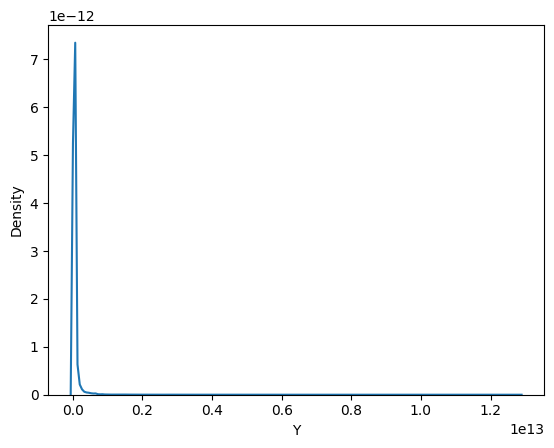

In [ ]:
# Melihat hasil prediksi terhadap test data
sns.kdeplot(sub["Y"])

In [ ]:
# Load kembali masing-masing hasil prediksi
sub1 = pd.read_csv("sub 1.csv")
sub2 = pd.read_csv("sub 2.csv")
sub3 = pd.read_csv("sub 3.csv")

In [ ]:
# Melakukan averaging atau rata-rata hasil prediksi
sub["Y"] = (sub1["Y"] + sub2["Y"] + sub3["Y"]) / 3

In [ ]:
# Export dalam bentuk csv
sub.to_csv("sub 4.csv", index = False)